# Ejercicio 4
Intente resolver dos casos diferentes del problema TSP usando Simulated Annealing y un Algoritmo Evolutivo. El primer problema es de 29 ciudades y el segundo, de 101 ciudades.
Las ubicaciones de las ciudades se encuentran dentro de una matriz contenida en el archivo con extensión 'cities.npy' mientras que los costos de ir de una ciudad a otra están contenidos en otra matriz almacenada en el archivo con extensión 'distances.npy'. Para ambos casos, se conocen las soluciones óptimas, las cuales se encuentran en los archivos con extensión 'opt.tour.npy'.
 
Se pide que:

a) Proponga una representación adecuada para las soluciones.

b) Proponga una función de evaluación que le permita cali car que tan buena es una solución.

c) De na como se generarán las soluciones vecinas al usar Simulated Annealing y cuales serán los operadores empleados en el Algoritmo Evolutivo.

d) Implemente y pruebe lo de nido en los puntos anteriores. Evalúe los resultados obtenidos. Detalle todos los parámetros usados durante la ejecución de ambos algoritmos. Justi que.

In [10]:
import numpy as np
import matplotlib.pyplot as plt


#from matplotlib import pylab
#import mpld3

%matplotlib  inline
#mpld3.enable_notebook()

from busqueda_local import hill_climb
from busqueda_local import simulated_annealing
from deap import base, creator, tools, algorithms

In [11]:
# -*- coding: utf-8 -*-
"""
Ejercicio 4: Problema del Viajante.
"""

CIUDADES = np.load('bayg29.cities.npy')
DISTANCIAS = np.load('bayg29.distances.npy')
RECORRIDO_OPTIMO = np.load('bayg29.opt.tour.npy')  # Distancia mínima: 1610

#CIUDADES = np.load('eil101.cities.npy')
#DISTANCIAS = np.load('eil101.distances.npy')
#RECORRIDO_OPTIMO = np.load('eil101.opt.tour.npy')  # Distancia mínima: 629

def distancia_recorrido(recorrido):
    """ Devuelve el largo total del recorrido. """
    largo = 0
    ciudad_anterior = recorrido[-1]
    for ciudad in recorrido:
        largo += DISTANCIAS[ciudad_anterior, ciudad]
        ciudad_anterior = ciudad
    return largo


def mostrar_recorrido(recorrido):
    r = recorrido + [recorrido[0]]
    plt.figure(1)
    plt.clf()
    plt.plot(CIUDADES[0], CIUDADES[1], 'o')
    plt.plot(CIUDADES[0, r], CIUDADES[1, r], 'r')
    plt.show()



In [28]:
CIUDADES = 1047
gananciaPorH = 9
costoPorKm = 2500

# Simulated Annealing
## Nuevos

In [12]:
def nuevos():
    a=np.arange(CIUDADES.shape[1])
    np.random.shuffle(a)
    return a

In [13]:
DISTANCIAS.shape

(29, 29)

In [14]:
nuevos()

array([ 4, 26, 10,  0, 20,  3,  5, 17, 14, 19, 15, 18, 22, 27, 16, 28, 11,
       25, 13, 24,  8, 23,  2,  7,  9, 21,  1,  6, 12])

## Evaluacion

In [15]:
def evaluacion(x):
    return -distancia_recorrido(x)

## Vecinos

In [16]:
def invertirPos(x,pos1,pos2):
    aaa=x[pos1]
    x[pos1]=x[pos2]
    x[pos2]=aaa
    return x

def vecinos(x):
    v = []
    pos=np.random.randint(0,x.size,3)
    while pos[0]==pos[1] & pos[1]==pos[2]:
        pos=np.random.randint(0,x.size,3)
    v.append(invertirPos(x,pos[0],pos[1]))
#    v.append(invertirPos(x,pos[0],pos[2]))
#    v.append(invertirPos(x,pos[1],pos[2]))
    return v

## Defino Temperaturas

In [17]:
# Probabilidad prob de elejir soluciones peores con diferencia mayor a dif al inicio
dif  = 0.5
prob = 0.03
T_max = -dif / np.log(prob)
# Probabilidad prob de elejir soluciones peores con diferencia mayor a dif al final
dif  = 0.05
prob = 0.03
T_min = -dif / np.log(prob)
# Factor de reduccion de acuerdo a las iteraciones deseadas
N = 30
reduccion = np.exp(np.log(T_min / T_max) / N)

## Busco

In [18]:
def buscar(i):
    mejor = nuevos()
    e=0
    for j in range(i):
        mejor, evaluaciones = simulated_annealing(mejor, evaluacion, vecinos,
                                          T_max=T_max, 
                                          T_min=T_min, 
                                          reduccion=reduccion)
        e+=evaluaciones
    print("Cantidad de soluciones evaluadas:", evaluaciones)
    print("Valor de func para esa solución:", evaluacion(RECORRIDO_OPTIMO)-evaluacion(mejor))
    return

In [19]:
buscar(50)

('Cantidad de soluciones evaluadas:', 31)
('Valor de func para esa soluci\xc3\xb3n:', 3503)


# Algoritmo Evolutivo

## Defino Fitness Esperado

In [20]:
creator.create("Fitness", base.Fitness, weights=(evaluacion(RECORRIDO_OPTIMO),))
creator.create("Individual", list, fitness=creator.Fitness)

## Defino ADN del Individuo

In [21]:
def nuevoCamino():
    a=np.arange(CIUDADES.shape[1])
    np.random.shuffle(a)
    return a

In [22]:
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, nuevoCamino)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

## Defino Evaluacion, Seleccion y Mutacion

In [23]:
def evaluarADN(x):
    return [distancia_recorrido(x)]

In [24]:
toolbox.register("evaluate", evaluarADN)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.40)
toolbox.register("select", tools.selTournament, tournsize=5)

In [25]:
def main():    
    pop = toolbox.population(n=1000)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, stats=stats, halloffame=hof, verbose=True)
    return pop, logbook, hof

gen	nevals	avg    	min 	max 
0  	1000  	4737.53	3538	5818
1  	599   	4426.27	3308	5612
2  	567   	4225.22	3308	5608
3  	617   	4094.49	3242	5465
4  	579   	3967.8 	3090	5550
5  	600   	3862.32	3090	5387
6  	588   	3739.9 	2999	5287
7  	610   	3713.65	2772	5528
8  	579   	3609.35	2772	5829
9  	625   	3553.56	2756	5411
10 	582   	3439.52	2757	5373
11 	609   	3403.18	2655	5515
12 	594   	3339.86	2578	5477
13 	578   	3261.94	2473	5447
14 	626   	3233.12	2482	5466
15 	610   	3139.14	2463	5440
16 	613   	3087.06	2398	5372
17 	623   	3104.08	2398	5336
18 	576   	3012.58	2365	5568
19 	591   	3018.59	2327	5342
20 	590   	2909.13	2261	5641
21 	589   	2898.82	2121	5330
22 	605   	2895.34	2121	5512
23 	579   	2795.97	2121	5230
24 	575   	2806.81	2101	5464
25 	606   	2800.28	2101	5554
26 	602   	2762.62	2066	5621
27 	590   	2746.3 	2034	5596
28 	567   	2679.7 	1995	5341
29 	605   	2653.47	1952	5414
30 	605   	2655.26	1894	5407
31 	599   	2620.95	1894	5473
32 	603   	2485.16	1894	5547
33 	586   	248

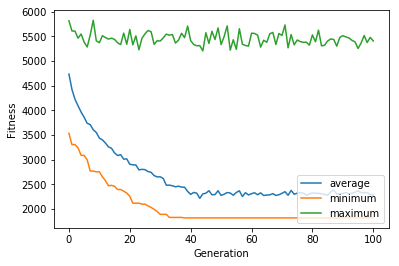

In [26]:
if __name__ == "__main__":
    pop, log, hof = main()
    print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
    gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")
    plt.plot(gen, avg, label="average")
    plt.plot(gen, min_, label="minimum")
    plt.plot(gen, max_, label="maximum")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend(loc="lower right")

('MEJOR RECORRIDO:', -1610)


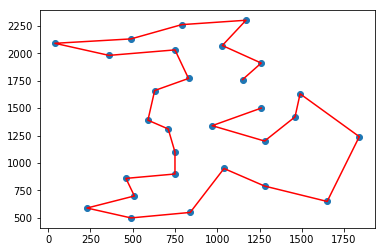

In [27]:
print("MEJOR RECORRIDO:",evaluacion(RECORRIDO_OPTIMO))
mostrar_recorrido(RECORRIDO_OPTIMO)